# Query Translation

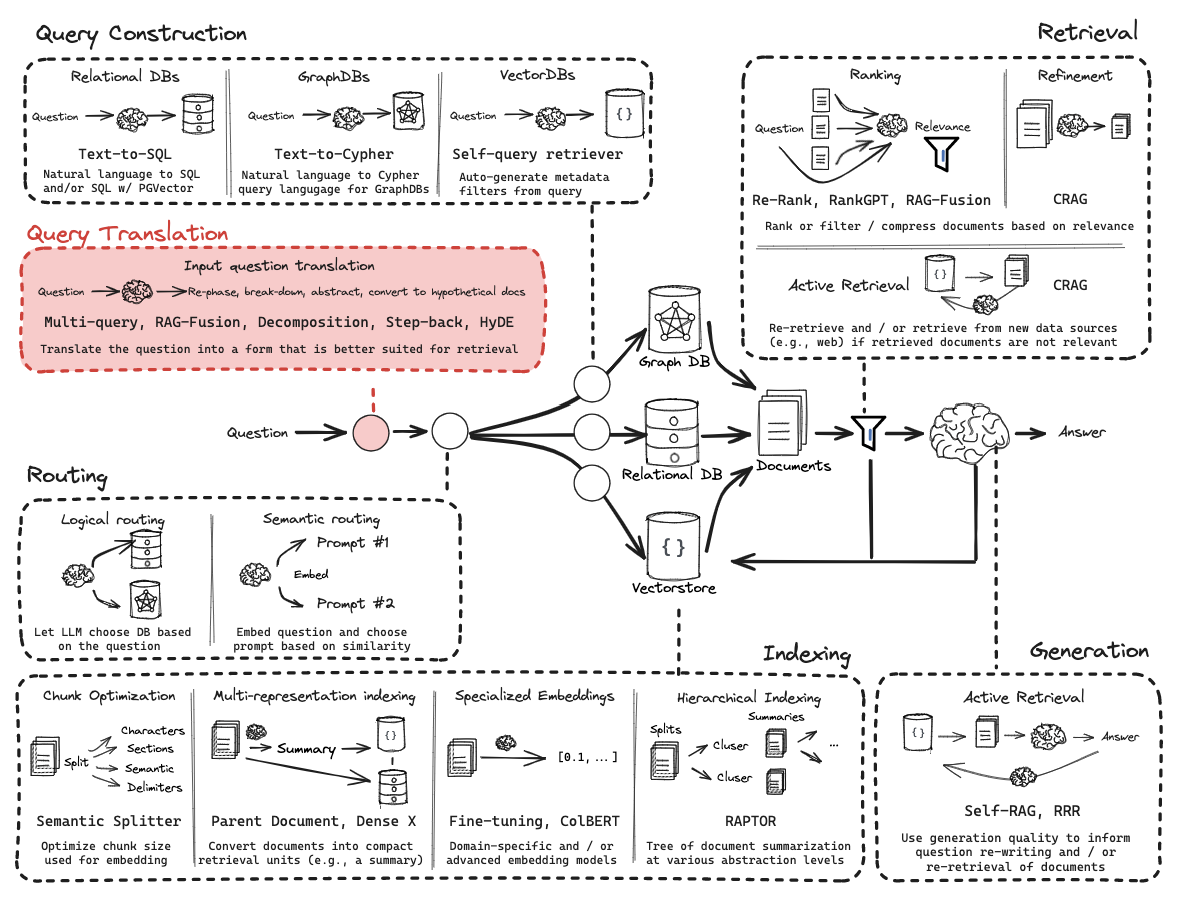

Query translation (or query transformation) is the process of converting a query into a different form that can be more efficiently executed or understood by a system, such as a database or search engine. This technique is common in information retrieval systems, databases, and natural language processing.

In [1]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

In [2]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_PROJECT'] = 'advanced-rag'
os.environ['LANGCHAIN_API_KEY'] = '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'


##  Multi Query

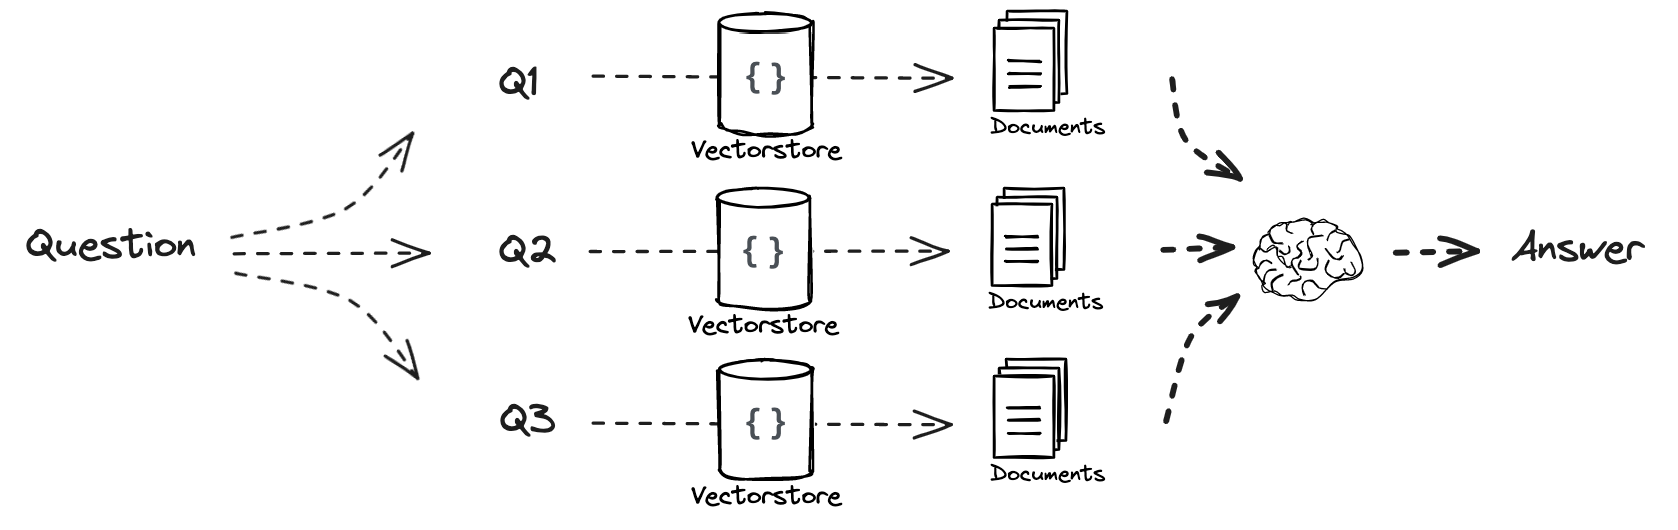

In [4]:
#### INDEXING ####

import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_ollama import ChatOllama
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from pydantic import BaseModel

loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

blog_docs = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300, 
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(blog_docs)

# Index
model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
hf_embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)
vectorstore = FAISS.from_documents(documents=splits, 
                                    embedding=hf_embeddings)

retriever = vectorstore.as_retriever()

e:\Programs\anaconda3\envs\LLMs\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Multi Query Prompt


In [19]:
from langchain.prompts import ChatPromptTemplate

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by one newline, just one newline .
DON'T ADD ANY TEXT RATHER THAN THE FIVE DIFFERENT QUESTIONS Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

generate_queries = (
    prompt_perspectives 
    | ChatOllama(model = 'llama3.1',temperature=0) 
    | StrOutputParser() 
    | (lambda x: [query.strip() for query in x.split("\n") if query.strip()])
)

In [20]:
result = generate_queries.invoke("What is Task Decomposition?")
result

['What are the key concepts and techniques involved in breaking down complex tasks into smaller sub-tasks?',
 'What does the literature say about the process of decomposing tasks into manageable components?',
 'Can you provide examples of task decomposition in real-world scenarios, such as project management or software development?',
 'How do experts approach task decomposition to improve efficiency and productivity?',
 'What are some common pitfalls or challenges associated with task decomposition that can be avoided?']

In [21]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "What is task decomposition for LLM agents?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)


9

In [22]:
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Finite context length: The restricted context capacity limits the inclusion of historical information, detailed instructions, API call context, and responses. The design of the system has to work with this limited communication bandwidth, while mechanisms like self-reflection to learn from past mistakes would benefit a lot from long or infinite context windows. Although vector stores and retrieval can provide access to a larger knowledge pool, their representation power is not as powerful as full attention.\n\n\nChallenges in long-term planning and task decomposition: Planning over a lengthy history and effectively exploring the solution space remain challenging. LLMs struggle to adjust plans when faced with unexpected errors, making them less robust compared to humans who learn from trial and error.\n\n\nReliability of natural language interface: Current agent system relies on natural 

In [23]:
# Helper function for printing docs
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [
                f"Document {i+1}:\n\n{d.page_content}\nMetadata: {d.metadata}"
                for i, d in enumerate(docs)
            ]
        )
    )
pretty_print_docs(docs)
    

Document 1:

Finite context length: The restricted context capacity limits the inclusion of historical information, detailed instructions, API call context, and responses. The design of the system has to work with this limited communication bandwidth, while mechanisms like self-reflection to learn from past mistakes would benefit a lot from long or infinite context windows. Although vector stores and retrieval can provide access to a larger knowledge pool, their representation power is not as powerful as full attention.


Challenges in long-term planning and task decomposition: Planning over a lengthy history and effectively exploring the solution space remain challenging. LLMs struggle to adjust plans when faced with unexpected errors, making them less robust compared to humans who learn from trial and error.


Reliability of natural language interface: Current agent system relies on natural language as an interface between LLMs and external components such as memory and tools. Howeve

## RAG-Fusion

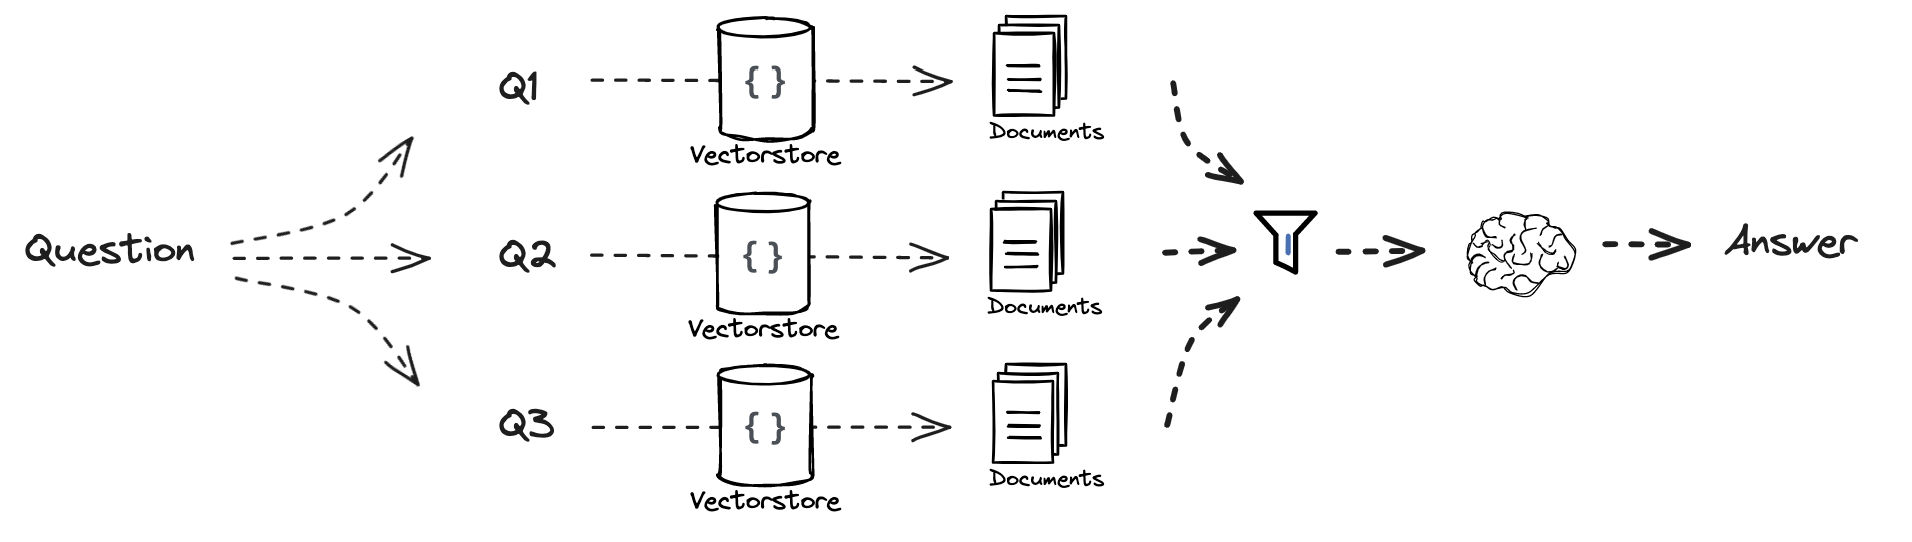

In [24]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_ollama import ChatOllama
# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)



generate_queries = (
    prompt_rag_fusion 
    | ChatOllama(model="llama3.1",temperature=0)
    | StrOutputParser() 
    | (lambda x: [query.strip() for query in x.split("\n") if query.strip()])
)

### Understanding Reciprocal Rank Fusion (RRF)



#### What is RRF?

Reciprocal Rank Fusion (RRF) is a method used to combine multiple ranked lists into a single, unified ranking. It's particularly useful in information retrieval and recommendation systems where multiple queries or algorithms might produce different rankings for the same set of items.





#### How RRF Works

1. **Input**: Multiple ranked lists of the same items
2. **Process**: Calculate a score for each item based on its ranks in all lists
3. **Output**: A single list ranked by the calculated RRF scores



#### The RRF Formula

For each item, the RRF score is calculated as:

RRF score = Σ (1 / (k + r))


Where:
- Σ means "sum over all rankings"
- k is a constant (typically 60)
- r is the rank of the item in a particular list

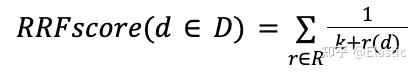

#### Example Scenario

Let's say we have three different queries (Q1, Q2, Q3) that rank four documents (A, B, C, D):

| Rank | Q1 | Q2 | Q3 |
|------|----|----|----| 
| 1    | A  | C  | D  |
| 2    | D  | A  | C  |
| 3    | C  | B  | A  |
| 4    | B  | D  | B  |

#### Calculating RRF Scores

Let's calculate the RRF score for Document A:

1. In Q1: rank 1 → 1 / (60 + 1) = 1/61
2. In Q2: rank 2 → 1 / (60 + 2) = 1/62
3. In Q3: rank 3 → 1 / (60 + 3) = 1/63

RRF(A) = 1/61 + 1/62 + 1/63 ≈ 0.0487

#### Final Ranking

After calculating scores for all documents:

1. Document A: 0.0487
2. Document C: 0.0486
3. Document D: 0.0484
4. Document B: 0.0469

#### Why RRF is Effective

1. **Balances multiple perspectives**: Combines rankings from different algorithms or queries
2. **Handles ties gracefully**: Similar ranks contribute similar scores
3. **Diminishing returns**: Top ranks have more influence, but lower ranks still contribute
4. **Scalability**: Works well with varying numbers of input rankings



In [25]:
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

11

In [27]:
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
llm = ChatOllama(model='llama3.1',temperatute =0)
question = "What is task decomposition for LLM agents?"

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, 
     #"question": itemgetter("question"),
     "question": RunnablePassthrough(),
     } 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke(question)

'According to the text, task decomposition refers to breaking down a complex user request into multiple tasks that can be executed by an LLM (Large Language Model) agent. This process involves parsing the user input into several tasks, each with its own attributes such as task type, ID, dependencies, and arguments. The LLM agent uses few-shot examples to guide the decomposition of the user request into manageable tasks.'

## Query Decomposition 

In [31]:
from langchain.prompts import ChatPromptTemplate

# Decomposition
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
DON'T RETURN ANY TEXT RATHER THAN THE GENERATED QUESTIONS ONLY 
Generate multiple search queries related to: {question} \n
Output (3 queries):"""
prompt_decomposition = ChatPromptTemplate.from_template(template)

In [32]:
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import StrOutputParser

# LLM
llm = ChatOllama(model = "llama3.1",temperature=0)

# Chain
generate_queries_decomposition = ( 
                                    prompt_decomposition
                                    | llm 
                                    | StrOutputParser() 
                                    | (lambda x: [query.strip() for query in x.split("\n") if query.strip()])
                                    )

# Run
question = "What are the main components of an LLM-powered autonomous agent system?"
questions = generate_queries_decomposition.invoke({"question":question})
questions

['1. What is the role of a knowledge graph in an LLM-powered autonomous agent system?',
 '2. How does a natural language understanding module contribute to the overall functionality of an LLM-powered autonomous agent system?',
 '3. What are the key components of a decision-making framework used in an LLM-powered autonomous agent system?']

#### Answer recursively  



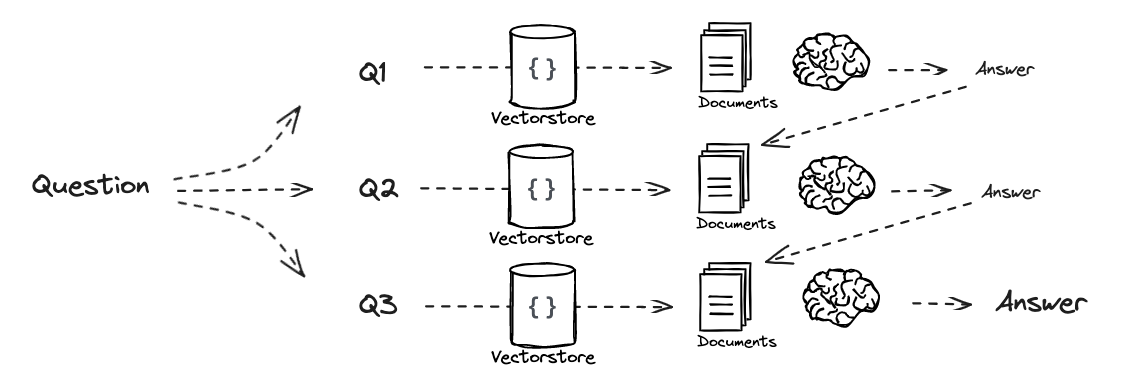

In [34]:
# Prompt
template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question: 

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

In [35]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

def format_qa_pair(question, answer):
    """Format Q and A pair"""
    
    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()

# llm
llm = ChatOllama(model = "llama3.1",temperature=0)

q_a_pairs = ""
for q in questions:
    
    rag_chain = (
    {"context": itemgetter("question") | retriever, 
     "question": itemgetter("question"),
     "q_a_pairs": itemgetter("q_a_pairs")} 
    | decomposition_prompt
    | llm
    | StrOutputParser())

    answer = rag_chain.invoke({"question":q,"q_a_pairs":q_a_pairs})
    q_a_pair = format_qa_pair(q,answer)
    q_a_pairs = q_a_pairs + "\n---\n"+  q_a_pair
    print("The question: ",q)
    print("The answer: ",answer)
    print("-"*100)
    print("The q_a_pairs: ",q_a_pairs)
    print("-"*100)

The question:  1. What is the role of a knowledge graph in an LLM-powered autonomous agent system?
The answer:  Based on the provided context, there is no direct mention of a knowledge graph's role in an LLM-powered autonomous agent system. However, we can infer its potential role based on the discussion of other components and architectures.

In the context of MRKL (Modular Reasoning, Knowledge and Language), it is mentioned that a MRKL system contains a collection of "expert" modules, which can be neural or symbolic. These modules are used to provide specific knowledge or functionality to the LLM-powered autonomous agent system. A knowledge graph could potentially serve as one type of expert module, providing a structured representation of knowledge that the LLM can draw upon.

In this scenario, the knowledge graph would likely play a role in:

* Providing domain-specific knowledge and facts to inform the LLM's decision-making process
* Enabling the LLM to reason about complex tasks 

#### Answer individually 


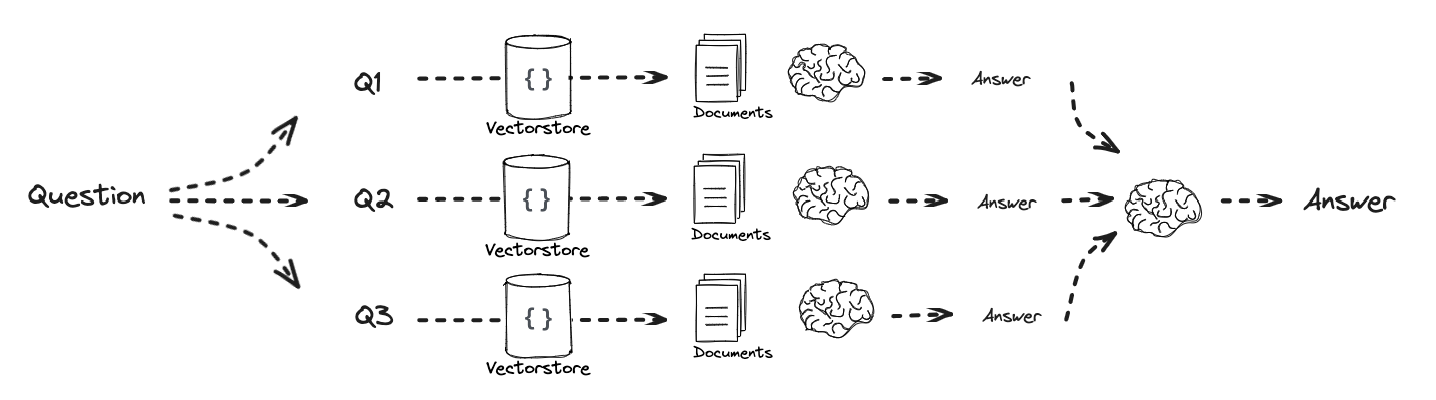

In [ ]:
# Answer each sub-question individually 

from langchain import hub
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_ollama import ChatOllama

# RAG prompt
prompt_rag = hub.pull("rlm/rag-prompt")

def retrieve_and_rag(question,prompt_rag,sub_question_generator_chain):
    """RAG on each sub-question"""
    llm = ChatOllama(model = 'llama3.1')
    # Use our decomposition / 
    sub_questions = sub_question_generator_chain.invoke({"question":question})
    
    # Initialize a list to hold RAG chain results
    rag_results = []
    
    for sub_question in sub_questions:
        
        # Retrieve documents for each sub-question
        retrieved_docs = retriever.get_relevant_documents(sub_question)
        
        # Use retrieved documents and sub-question in RAG chain
        answer = (prompt_rag | llm | StrOutputParser()).invoke({"context": retrieved_docs, 
                                                                "question": sub_question})
        rag_results.append(answer)
    
    return rag_results,sub_questions

# Wrap the retrieval and RAG process in a RunnableLambda for integration into a chain
answers, questions = retrieve_and_rag(question, prompt_rag, generate_queries_decomposition)

In [ ]:
def format_qa_pairs(questions, answers):
    """Format Q and A pairs"""
    
    formatted_string = ""
    for i, (question, answer) in enumerate(zip(questions, answers), start=1):
        formatted_string += f"Question {i}: {question}\nAnswer {i}: {answer}\n\n"
    return formatted_string.strip()

context = format_qa_pairs(questions, answers)

# Prompt
template = """Here is a set of Q+A pairs:

{context}

Use these to synthesize an answer to the question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"context":context,"question":question})

## Resources

- [How to use the MultiQueryRetriever by 🦜🔗](https://python.langchain.com/docs/how_to/MultiQueryRetriever/)
- [Reciprocal Rank Fusion (RRF)](https://medium.com/@devalshah1619/mathematical-intuition-behind-reciprocal-rank-fusion-rrf-explained-in-2-mins-002df0cc5e2a)